### Notebook SP4 - Exploration of model rejection power of the constant-rate hypothesis and analysis of estimated parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import spearmanr, linregress
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
from statsmodels.stats.multitest import multipletests

# import custom functions
from MCMC_pipe import import_data

In [2]:
sns.set_context('talk')
sns.set_style('white')

#### A) Data import and preparation

In [3]:
# data import
M_data, P_data, Psem_data, M_interp_dict, beta_gamma_dist, delta_gamma_dist, Pmodel_data = \
    import_data(import_folder='processed_data/')

# rename columns for mrna, protein and sem to v1-v6
col_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']
M_data.columns = col_names
P_data.columns = col_names
Psem_data.columns = col_names
Pmodel_data.columns = col_names

In [6]:
# read MCMC parameter results and sort alphabetically
results_df = pd.read_csv('extracted_results/MCMC_result_collection.csv', index_col=0)
results_df.sort_index(inplace=True)

In [8]:
# add a columnd for half life in hours, build on mode
results_df['half life (hours)'] = np.log(2)/results_df['delta_mode']

In [9]:
# from "gene name", extract simulation parameters
results_df['sim_mRNA_type'] = [x.split('_')[0] for x in results_df.index]
results_df['sim_half-life'] = [np.float(x.split('_')[3]) for x in results_df.index]
results_df['sim_phi'] = [float(x.split('_')[3])/float(x.split('_')[5]) for x in results_df.index]
results_df['sim_RSE'] = [np.round((float(x.split('_')[8].split('[')[1]) + float(x.split('_')[9].split(']')[0]))/2, 2) for x in results_df.index]
results_df['sim_repeat'] = [x.split('_rep')[1] for x in results_df.index]
results_df['lower villus half-life'] = results_df['sim_half-life']
results_df['upper villus half-life'] = results_df['sim_half-life'] / results_df['sim_phi']

In [10]:
# add column to see whether the model was rejected based on p value
results_df['pval>0.05'] = (results_df['pp_pval'] >= 0.05)
# add column to indicate whether half-life went from low to high or high to low
results_df['sim_half-life_change'] = ['l2s' if x > 1 else 's2l' if x < 1 else 'const' for x in results_df['sim_phi']]
# add column for combined model type
results_df['sim_type'] = results_df['sim_mRNA_type'] + '_' +results_df['sim_half-life_change']

In [11]:
# add column with bh fdr rate
reject, FDRvals, _, _ = multipletests(results_df['pp_pval'].tolist(), alpha=0.25, method='fdr_bh', is_sorted=False, returnsorted=False)
results_df['BH_FDR'] = FDRvals
results_df['BH_pass'] = [not x for x in reject]

#### B) Exploration of rejection power

#### Rejection probability heatmap

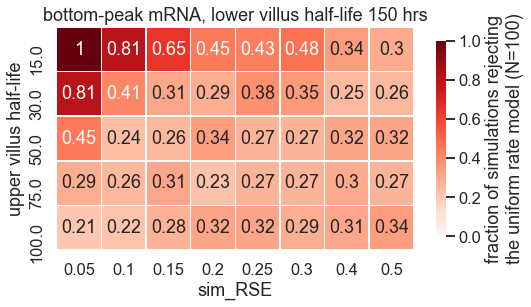

In [140]:
# extract one model type only
bottom_l2s_df = results_df[(results_df['sim_type']=='bottom_l2s')]
bottom_l2s_gr = bottom_l2s_df.groupby(['upper villus half-life', 'sim_RSE']).mean()['BH_pass'].reset_index().pivot(index='upper villus half-life', columns='sim_RSE', values='BH_pass')

sns.set(rc={"figure.figsize":(8, 4.5)})
sns.set_context('talk')
ax = sns.heatmap(1-bottom_l2s_gr, square=True, linewidths=.5, annot=True,
                 cbar_kws={'shrink': 0.8, 'label':'fraction of simulations rejecting\nthe uniform rate model (N=100)'}, cmap='Reds',vmin=0, vmax=1)

ax.set_title('bottom-peak mRNA, lower villus half-life 150 hrs')
plt.savefig('figures/heat_bottom_l2s.pdf', bbox_inches='tight')

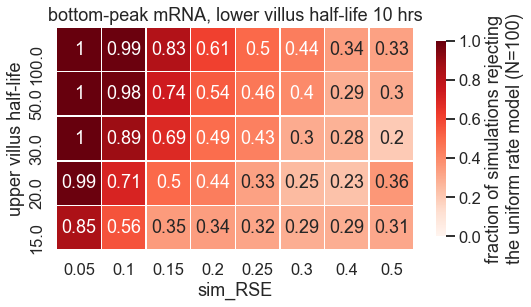

In [141]:
# extract one model type only
bottom_s2l_df = results_df[(results_df['sim_type']=='bottom_s2l')]
bottom_s2l_gr = bottom_s2l_df.groupby(['upper villus half-life', 'sim_RSE']).mean()['BH_pass'].reset_index().pivot(index='upper villus half-life', columns='sim_RSE', values='BH_pass')

sns.set(rc={"figure.figsize":(8, 4.5)})
sns.set_context('talk')
ax = sns.heatmap(1-bottom_s2l_gr, square=True, linewidths=.5, annot=True,
                 cbar_kws={'shrink': 0.8, 'label':'fraction of simulations rejecting\nthe uniform rate model (N=100)'}, cmap='Reds',vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_title('bottom-peak mRNA, lower villus half-life 10 hrs')
plt.savefig('figures/heat_bottom_s2l.pdf', bbox_inches='tight')

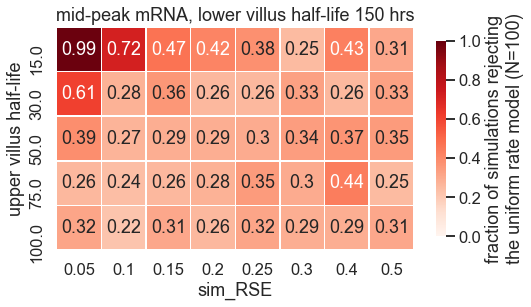

In [142]:
# extract one model type only
mid_l2s_df = results_df[(results_df['sim_type']=='mid_l2s')]
mid_l2s_gr = mid_l2s_df.groupby(['upper villus half-life', 'sim_RSE']).mean()['BH_pass'].reset_index().pivot(index='upper villus half-life', columns='sim_RSE', values='BH_pass')


sns.set(rc={"figure.figsize":(8, 4.5)})
sns.set_context('talk')
ax = sns.heatmap(1-mid_l2s_gr, square=True, linewidths=.5, annot=True,
                 cbar_kws={'shrink': 0.8, 'label':'fraction of simulations rejecting\nthe uniform rate model (N=100)'}, cmap='Reds',vmin=0, vmax=1)

ax.set_title('mid-peak mRNA, lower villus half-life 150 hrs')
plt.savefig('figures/heat_mid_l2s.pdf', bbox_inches='tight')

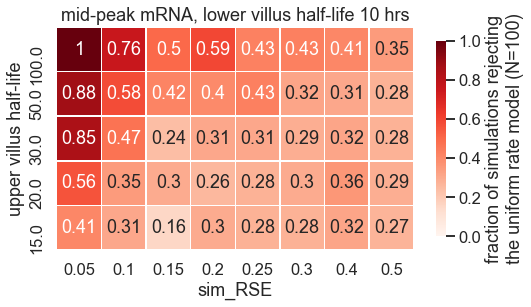

In [81]:
# extract one model type only
mid_s2l_df = results_df[(results_df['sim_type']=='mid_s2l')]
mid_s2l_gr = mid_s2l_df.groupby(['upper villus half-life', 'sim_RSE']).mean()['BH_pass'].reset_index().pivot(index='upper villus half-life', columns='sim_RSE', values='BH_pass')

sns.set(rc={"figure.figsize":(8, 4.5)})
sns.set_context('talk')
ax = sns.heatmap(1-mid_s2l_gr, square=True, linewidths=.5, annot=True,
                 cbar_kws={'shrink': 0.8, 'label':'fraction of simulations rejecting\nthe uniform rate model (N=100)'}, cmap='Reds',vmin=0, vmax=1)
ax.invert_yaxis()
ax.set_title('mid-peak mRNA, lower villus half-life 10 hrs')
plt.savefig('figures/heat_mid_s2l.pdf', bbox_inches='tight')

#### Investigation of half-life estimates under the constant-rate assumption for non constant-rate simulations

In [99]:
# further analysis of fit results 
# get part of the df with low noise only
low_noise_df = results_df[results_df['sim_RSE']<0.25]

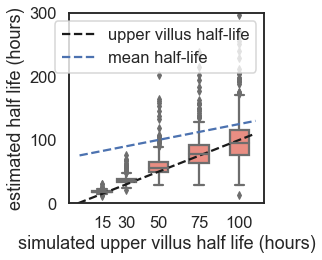

In [148]:
#select data for this plot
sns.set_style('white')
select_df = low_noise_df[(low_noise_df['sim_type']=='bottom_l2s')]
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
sns.set_style('white')
sns.boxplot(x='upper villus half-life', y='half life (hours)', data=select_df, ax=ax, order=np.arange(151), width=12, color='salmon')
ax.set_ylim([0, 400])

ax.plot([0,110], [0,110], '--k', label='upper villus half-life')
ax.plot([1, 110], [np.mean([1, select_df['lower villus half-life'].unique()[0]]), np.mean([110, select_df['lower villus half-life'].unique()[0]])], '--', label='mean half-life')

ax.set_xticks(select_df['upper villus half-life'].unique())
ax.set_ylim([0, 300])
ax.set_xlabel('simulated upper villus half life (hours)')
ax.set_ylabel('estimated half life (hours)')
plt.legend()
plt.savefig('figures/estimates_bottom_l2s.pdf', bbox_inches='tight')

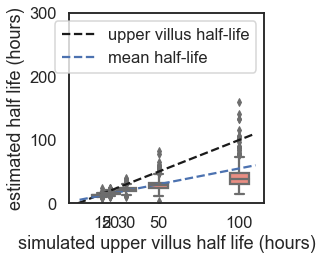

In [149]:
#select data for this plot
select_df = low_noise_df[(low_noise_df['sim_type']=='bottom_s2l')]
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
sns.set_style('white')
sns.boxplot(x='upper villus half-life', y='half life (hours)', data=select_df, ax=ax, order=np.arange(151), width=12, color='salmon')
ax.set_ylim([0, 400])
ax.plot([0,110], [0,110], '--k', label='upper villus half-life')
ax.plot([1, 110], [np.mean([1, select_df['lower villus half-life'].unique()[0]]), np.mean([110, select_df['lower villus half-life'].unique()[0]])], '--', label='mean half-life')

ax.set_xticks(select_df['upper villus half-life'].unique())
ax.set_ylim([0, 300])
ax.set_xlabel('simulated upper villus half life (hours)')
ax.set_ylabel('estimated half life (hours)')
plt.legend()
plt.savefig('figures/estimates_bottom_s2l.pdf', bbox_inches='tight')

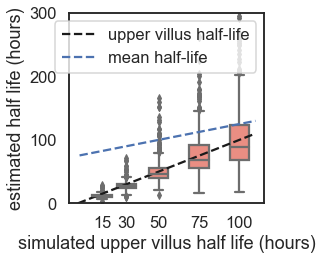

In [150]:
#select data for this plot
select_df = low_noise_df[(low_noise_df['sim_type']=='mid_l2s')]
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
sns.set_style('white')
sns.boxplot(x='upper villus half-life', y='half life (hours)', data=select_df, ax=ax, order=np.arange(151), width=12, color='salmon')
ax.set_ylim([0, 400])
ax.plot([0,110], [0,110], '--k', label='upper villus half-life')
ax.plot([1, 110], [np.mean([1, select_df['lower villus half-life'].unique()[0]]), np.mean([110, select_df['lower villus half-life'].unique()[0]])], '--', label='mean half-life')

ax.set_xticks(select_df['upper villus half-life'].unique())
ax.set_ylim([0, 300])
ax.set_xlabel('simulated upper villus half life (hours)')
ax.set_ylabel('estimated half life (hours)')
plt.legend()
plt.savefig('figures/estimates_mid_l2s.pdf', bbox_inches='tight')

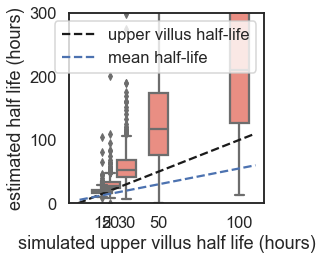

In [151]:
#select data for this plot
select_df = low_noise_df[(low_noise_df['sim_type']=='mid_s2l')]
fig, ax = plt.subplots(1,1, figsize=(3.5, 3.5))
sns.set_style('white')
sns.boxplot(x='upper villus half-life', y='half life (hours)', data=select_df, ax=ax, order=np.arange(151), width=12, color='salmon')
ax.set_ylim([0, 400])
ax.plot([0,110], [0,110], '--k', label='upper villus half-life')
ax.plot([1, 110], [np.mean([1, select_df['lower villus half-life'].unique()[0]]), np.mean([110, select_df['lower villus half-life'].unique()[0]])], '--', label='mean half-life')

ax.set_xticks(select_df['upper villus half-life'].unique())
ax.set_ylim([0, 300])
ax.set_xlabel('simulated upper villus half life (hours)')
ax.set_ylabel('estimated half life (hours)')
plt.legend()
plt.savefig('figures/estimates_mid_s2l.pdf', bbox_inches='tight')